In [1]:
#importing the necessary dependencies

from caffe.proto import caffe_pb2
from layers import Fixations
from urllib import urlretrieve
from utils import *
import caffe
import os

%matplotlib inline

In [2]:
#initializing the model

# Specifying to use the GPU
caffe.set_mode_gpu()
caffe.set_device(0)

model_path = os.path.join('../models', 'bvlc_googlenet', 'bvlc_googlenet.caffemodel')
if not os.path.isfile(model_path):
        print('Downloading GoogLeNet weights...')
        urlretrieve ("http://dl.caffe.berkeleyvision.org/bvlc_googlenet.caffemodel", model_path)

net = caffe.Classifier('../models/bvlc_googlenet/deploy.prototxt', model_path, channel_swap=(2,1,0))
layers = Fixations(net)

In [3]:
def googlenet(points, inc, resFac):
    points = layers.fc(points=points, layer='loss3/classifier', prevLayer='pool5/7x7_s1')
    points = layers.pool(points=points, prevLayer='inception_5b/output', K=7, S=1)
    points = layers.inception(points, 'inception_5b', 'inception_5a')
    points = layers.inception(points, 'inception_5a', 'pool4/3x3_s2', pool=True)
    points = layers.pool(points=points, prevLayer='inception_4e/output', K=3, S=2)
    points = layers.inception(points, 'inception_4e', 'inception_4d')
    points = layers.inception(points, 'inception_4d', 'inception_4c')
    points = layers.inception(points, 'inception_4c', 'inception_4b')
    points = layers.inception(points, 'inception_4b', 'inception_4a')
    points = layers.inception(points, 'inception_4a', 'pool3/3x3_s2', pool=True)
    points = layers.pool(points=points, prevLayer='inception_3b/output', K=3, S=2)
    points = layers.inception(points, 'inception_3b', 'inception_3a')
    points = layers.inception(points, 'inception_3a', 'pool2/3x3_s2', pool=True)
    points = layers.pool(points=points, prevLayer='conv2/3x3', K=3, S=2)
    points = layers.conv(points=points,  layer='conv2/3x3', prevLayer='conv2/3x3_reduce', K=3, S=1, P=1)
    points = layers.conv(points=points,  layer='conv2/3x3_reduce', prevLayer='pool1/3x3_s2', K=1, S=1, P=0)
    points = layers.pool(points=points, prevLayer='conv1/7x7_s2', K=3, S=2)
    points = layers.conv(points=points,  layer='conv1/7x7_s2', prevLayer='data', K=7, S=2, P=3)
    points = layers.data(points=points, inc=inc, resFac=resFac)
    return points

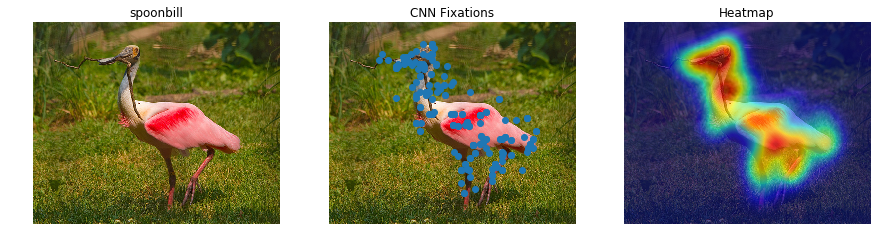

In [6]:
img_path = '../../data/ILSVRC_Validation/Images/ILSVRC2012_val_00000043.JPEG'
img, offset, resFac, newSize = imgPreprocess(img_path=img_path)
net.image_dims = newSize
points, image_label = pred(net, img)
points = googlenet(points, offset, resFac)
visualize(img_path, points, diag_percent=0.1, image_label=image_label)